In [1]:
import os
import numpy as np
import tensorflow
import pandas as pd

from tensorflow.keras.applications.resnet import ResNet152
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Reshape, Dropout, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import shutil
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
%matplotlib inline

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
os.listdir('../Final FYP/input')

['HAM10000_images_part_1',
 'HAM10000_images_part_2',
 'HAM10000_metadata.csv',
 'hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_L.csv',
 'hmnist_8_8_RGB.csv']

In [4]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 7 folders inside 'base_dir':

# train_dir
    # nv
    # mel
    # bkl
    # bcc
    # akiec
    # vasc
    # df
 
# val_dir
    # nv
    # mel
    # bkl
    # bcc
    # akiec
    # vasc
    # df

# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN, VALIDATION AND TEST FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)



# create new folders inside val_dir
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)

In [6]:
df_data = pd.read_csv('../Final FYP/input/HAM10000_metadata.csv')

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
# this will tell us how many images are associated with each lesion_id
df = df_data.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [8]:
# here we identify lesion_id's that have duplicate images and those that have only
# one image.

def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [9]:
df_data['duplicates'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [10]:
# now we filter out images that don't have duplicates
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape

(5514, 8)

In [11]:
# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = df['dx']

_, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)

df_val.shape

(938, 8)

In [12]:
df_val['dx'].value_counts()

nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: dx, dtype: int64

In [13]:
# This set will be df_data excluding all rows that are in the val set

# This function identifies if an image is part of the train
# or val set.
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows

# create a new colum that is a copy of the image_id column
df_data['train_or_val'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

9077
938


In [14]:
df_train['dx'].value_counts()

nv       5954
mel      1074
bkl      1024
bcc       484
akiec     301
vasc      131
df        109
Name: dx, dtype: int64

In [15]:
df_val['dx'].value_counts()

nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: dx, dtype: int64

In [16]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [18]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('../Final FYP/input/ham10000_images_part_1')
folder_2 = os.listdir('../Final FYP/input/ham10000_images_part_2')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('../Final FYP/input/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('../Final FYP/input/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('../Final FYP/input/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('../Final FYP/input/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
        

In [19]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5954
1074
1024
484
301
131
109


In [20]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))
751

751
39
75
30
26
11
6


751

In [21]:
# note that we are not augmenting class 'nv'
class_list = ['mel','bkl','bcc','akiec','vasc','df']

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 6000 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 1074 images belonging to 1 classes.
Found 1024 images belonging to 1 classes.
Found 484 images belonging to 1 classes.
Found 301 images belonging to 1 classes.
Found 131 images belonging to 1 classes.
Found 109 images belonging to 1 classes.


In [22]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5954
5920
5920
5858
5217
5290
4410


In [23]:
# Check how many val images we have in each folder.

print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

751
39
75
30
26
11
6


In [24]:
#Set up Generators

train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [25]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 38569 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


In [27]:
base_model = ResNet152(include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_batches.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = True

In [28]:
model_folder = '../Final FYP'
model_path = os.path.join('Model_Weight',model_folder)
os.mkdir(model_path)
filepath = os.path.join(model_path,"{epoch:02d}_{loss:.3f}_{val_loss:.3f}_{categorical_accuracy:02.4f}_{val_categorical_accuracy:02.4f}_{mel_recall:.2f}_{val_mel_recall:.2f}.h5")

In [29]:
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=False, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, 
                                   verbose=1, mode='min', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

In [30]:
nv = os.path.join(train_path, 'nv')
nv_folder = os.listdir(nv)
nv_size = len(nv_folder)
mel = os.path.join(train_path, 'mel')
mel_folder = os.listdir(mel)
mel_size = len(mel_folder)
bkl = os.path.join(train_path, 'bkl')
bkl_folder = os.listdir(bkl)
bkl_size = len(bkl_folder)
bcc = os.path.join(train_path, 'bcc')
bcc_folder = os.listdir(bcc)
bcc_size = len(bcc_folder)
df = os.path.join(train_path, 'df')
df_folder = os.listdir(df)
df_size = len(df_folder)
vasc = os.path.join(train_path, 'vasc')
vasc_folder = os.listdir(vasc)
vasc_size = len(vasc_folder)
akiec = os.path.join(train_path, 'akiec')
akiec_folder = os.listdir(akiec)
akiec_size = len(akiec_folder)

total = nv_size + mel_size + bkl_size + bcc_size + df_size + vasc_size + akiec_size
class_weights={
    0: total/akiec_size/7, # akiec
    1: total/bcc_size/7, # bcc
    2: total/bkl_size/7, # bkl
    3: total/df_size/7, # df
    4: total/mel_size/7, # mel
    5: total/nv_size/7, # nv
    6: total/vasc_size/7, # vasc
}

In [31]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=[categorical_accuracy,tensorflow.keras.metrics.Recall(class_id = 4, name = 'mel_recall')])

history = model.fit(train_batches, steps_per_epoch=train_steps,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    class_weight=class_weights,
                    epochs=30, verbose=1,
                    callbacks=callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 908.0 steps, validate for 94.0 steps
Epoch 1/30
907/908 [============================>.] - ETA: 0s - loss: 0.9332 - categorical_accuracy: 0.6540 - mel_recall: 0.3965
Epoch 00001: saving model to Model_Weight\../Final FYP\01_0.933_7.293_0.6540_0.2484_0.40_0.10.h5
908/908 [==============================] - 250s 276ms/step - loss: 0.9331 - categorical_accuracy: 0.6540 - mel_recall: 0.3967 - val_loss: 7.2928 - val_categorical_accuracy: 0.2484 - val_mel_recall: 0.1026
Epoch 2/30
907/908 [============================>.] - ETA: 0s - loss: 0.5895 - categorical_accuracy: 0.7857 - mel_recall: 0.5690
Epoch 00002: saving model to Model_Weight\../Final FYP\02_0.589_0.467_0.7857_0.8401_0.57_0.28.h5
908/908 [==============================] - 228s 251ms/step - loss: 0.5893 - categorical_accuracy: 0.7857 - mel_recall: 0.5693 - val_loss: 0.4674 - val_categorical_accuracy: 0.8401 - val_mel_recall: 0.2821
Epoch 3/30
907/908 [=====================

In [32]:
# plot curves
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
mel_recall = history.history['mel_recall']
val_mel_recall = history.history['val_mel_recall']
epochs = range(1, len(acc) + 1)

<Figure size 432x288 with 0 Axes>

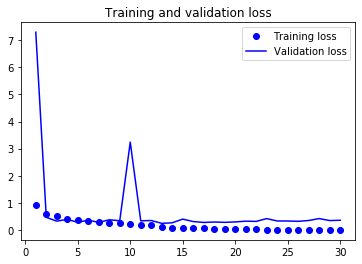

<Figure size 432x288 with 0 Axes>

In [33]:
# loss graph
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig(os.path.join(model_path,'loss.png'))
plt.figure()


<Figure size 432x288 with 0 Axes>

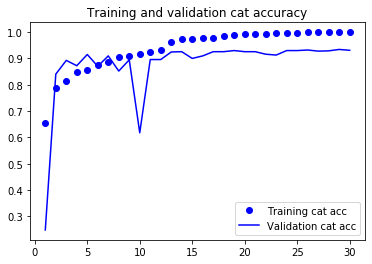

<Figure size 432x288 with 0 Axes>

In [34]:
# accuracy graph
plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.savefig(os.path.join(model_path,'acc.png'))
plt.figure()

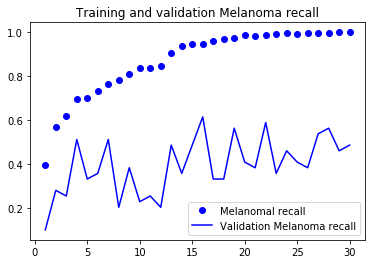

In [35]:
# recall graph
plt.plot(epochs, mel_recall, 'bo', label='Melanomal recall')
plt.plot(epochs, val_mel_recall, 'b', label='Validation Melanoma recall')
plt.title('Training and validation Melanoma recall')
plt.legend()
plt.savefig(os.path.join(model_path,'recall.png'))

In [40]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'categorical_accuracy', 'mel_recall']

In [41]:
# Here the the last epoch will be used.

val_loss, val_categorical_accuracy, val_mel_recall = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_categorical_accuracy:', val_categorical_accuracy)
print('val_mel_recall:', val_mel_recall)

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
val_loss: 0.37518140791207905
val_categorical_accuracy: 0.93070364
val_mel_recall: 0.4871795


In [53]:
# Here the the epoch 13, lowest loss weight will be used.

model.load_weights('../Final FYP/Weight/lowest_loss.h5')

val_loss, val_categorical_accuracy, val_mel_recall = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_categorical_accuracy:', val_categorical_accuracy)
print('val_mel_recall:', val_mel_recall)

  ...
    to  
  ['...']
val_loss: 0.2539216659215151
val_categorical_accuracy: 0.92430705
val_mel_recall: 0.4871795
